# Should Robots Be Obedient?

In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math, csv

In [2]:
default_palette = sns.cubehelix_palette(5, start=2.6, rot=0, dark=0.1, light=.8)
sns.set_style('white')
sns.set_context('paper', font_scale=1.4)
sns.set_style({
    'axes.linewidth' : 0.5, 
    'axes.edgecolor': '#cccccc',
    'lines.markersize': 3,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'lines.marker': 'o',
    'markers.fillstyle': 'full',
    'errorbar.capsize': 2
})
sns.despine()

<Figure size 432x288 with 0 Axes>

In [3]:
class Game:
    
    def __init__(self, num_actions, horizon,
                 reward_mean_prior, reward_cov_prior,
                 feat_mean_prior, feat_cov_prior):
        """
        Params:
            reward_mean_prior [np.ndarray]: E[theta]
            reward_cov_prior [np.ndarray]: Cov[theta]
            feat_mean_prior [np.ndarray]: E[phi]
            feat_cov_prior [np.ndarray]: Cov[phi]
            num_actions [int]: number of actions at each step
            horizon [int]: horizon of game
        """
        self.reward_mean_prior = reward_mean_prior
        self.reward_cov_prior = reward_cov_prior
        self.feat_mean_prior = feat_mean_prior
        self.feat_cov_prior = feat_cov_prior
        self.num_true_feats = len(self.feat_mean_prior)
        self.num_extra_feats = len(feat_mean_prior) - len(reward_mean_prior)
        self.feat_weights = np.random.multivariate_normal(
            self.reward_mean_prior, self.reward_cov_prior)
        self.feat_weights = np.hstack(
            [self.feat_weights, np.zeros(self.num_extra_feats)])
        self.num_actions = num_actions
        self.horizon = horizon
        self.action_matrix = np.random.multivariate_normal(
            self.feat_mean_prior, self.feat_cov_prior, 
            size=(self.horizon, self.num_actions))
        self.action_vals = np.dot(self.action_matrix, self.feat_weights.T)
        
    def get_reward(self, action, time):
        reward = self.action_vals[time][action]
        return reward
    
    def get_max_reward(self, time):
        return np.max(self.action_vals[time])
    
    def get_action_matrix_at_steps(self, steps):
        return self.action_matrix[steps]
    
    def get_action_matrix(self, max_step=None):
        if max_step:
            return self.action_matrix[:max_step]
        return self.action_matrix
        
class Human:
    
    def __init__(self, rationality):
        self.rationality = rationality
        
    def get_orders(self, game):
        probs = self.get_prob_orders(game.action_vals)
        inds = np.arange(game.num_actions)
        orders = np.array(
            [np.random.choice(inds, p=probs[i]) for i in range(len(probs))])
        return orders
    
    def get_prob_orders(self, action_vals):
        human_vals = action_vals/self.rationality
        max_vals = np.array(np.max(human_vals, axis=1))[:,np.newaxis]
        human_vals = human_vals - max_vals
        unnormalized_probs = np.exp(human_vals)
        normalizations = np.sum(unnormalized_probs, axis=1)
        probs = unnormalized_probs/normalizations[:,np.newaxis]
        return probs
        
class Robot:
    
    def __init__(self, num_feats):
        """
        Params:
            num_feats [int]: the number of feats the robot thinks theta has
        """
        self.num_feats = num_feats
        
    def choose_action(self, game, time, theta_est):
        action_matrix = game.action_matrix[time,:,:self.num_feats]
        robot_action = np.argmax(np.matmul(action_matrix, theta_est))
        return robot_action
    
    def get_robot_action_matrix(self, action_matrix):
        """
        Truncates action matrix to features that robot thinks are important.
        """
        return action_matrix[:,:,:self.num_feats]

    def calc_mle_theta(self, orders, action_matrix, human, max_iter=500):
        """
        Params:
            orders [list(int)]: the action ids the human chooses at diff rounds
            action_matrix [np.array((num_steps, num_actions, num_feats))]: 
                the feature vectors for the rounds corresponding to orders
            human [Human]
        """
        theta = np.zeros(self.num_feats)
        action_matrix = self.get_robot_action_matrix(action_matrix)
        empirical_feats = action_matrix[[i for i in range(len(orders))], orders]
        empirical_feats = np.sum(empirical_feats, axis=0)
        expected_feats = np.zeros(len(empirical_feats))
        diff = empirical_feats - expected_feats
        i = 0
        while np.linalg.norm(diff) > 0.1 and i < max_iter:
            action_vals = np.matmul(action_matrix, theta)
            prob_orders = human.get_prob_orders(action_vals)
            expected_feats = action_matrix * prob_orders[:,:,np.newaxis]
            expected_feats = np.sum(expected_feats, axis=(0, 1))
            diff = empirical_feats - expected_feats # gradient
            theta += 1/(i+1) * diff
            if any(np.isnan(diff)):
                print(expected_feats)
            i += 1
        return theta
    
def get_obedience(robot_action, order):
    return 1 if robot_action == order else 0

# **Autonomy Advantage vs Obedience**
Autonomy advantage and obedience come at a tradeoff. The robot obey less over time and the autonomy advantage of the robot become higher over time.
Although the more rational a human is the higher the max autonomy advantage is, but it harder and takes longer for the robot to reach max autonomy advantage.
This experiment was preformed with rationality values of 2,4,6,8,10.


In [4]:
def get_data_at_time(game, robot, human, orders, time):
    """
    Returns [obedience, is opt order, adv, max adv]
    """
    prev_orders = orders[:time+1]
    curr_order = prev_orders[-1]
    theta_est = robot.calc_mle_theta(
        prev_orders, game.get_action_matrix(len(prev_orders)), human)
    robot_action = robot.choose_action(game, time, theta_est)
    obd = get_obedience(robot_action, curr_order)
    human_reward = game.get_reward(curr_order, time)
    max_reward = game.get_max_reward(time)
    is_order_opt = 1 if human_reward == max_reward else 0
    adv = game.get_reward(robot_action, time) - human_reward
    max_adv = max_reward - human_reward
    return np.array([obd, is_order_opt, adv, max_adv])

def get_mean_stderr(data):
    mean = np.average(data, axis=0)
    std_error = np.sqrt(np.sum(np.square(data - mean), axis=0))/len(data)
    return mean, std_error

def sim_adv_obd_by_time(
    rationality=10, num_feats=10, num_actions=10, horizon=50, time_step=5, num_sims=100):
    times = range(0, horizon+1, time_step)
    # last index is [obedience, is order opt, adv, max adv]
    data = np.zeros((num_sims, len(times), 4))
    human = Human(rationality)
    robot = Robot(num_feats)
    for sim_num in range(num_sims):
        game = Game(num_actions, horizon+1, 
            np.zeros(num_feats), np.identity(num_feats), 
            np.zeros(num_feats), np.identity(num_feats))
        orders = human.get_orders(game)
        for time_ind, time in enumerate(times):
            data[sim_num][time_ind] = get_data_at_time(game, robot, human, orders, time)
    return data, times
    
def plot_sim_by_time(exps, times, ylabel, data_labels, linestyles):
    plt.figure()
    for exp_ind, data_label, linestyle in zip(
        range(exps.shape[-1]), data_labels, linestyles):
        mean, stderr = get_mean_stderr(exps[:,:,exp_ind])
        (_, caps, _) = plt.errorbar(
            times, mean, yerr=stderr, marker='o', 
            label=data_label, capsize=2, linestyle=linestyle)
        for cap in caps:
            cap.set_markeredgewidth(1)
        plt.xlabel('Time')
    plt.legend()
    plt.ylabel(ylabel)
    plt.locator_params(axis='y', nbins=3)
    sns.despine()
    
def save_adv_obd_data(filename, data, times):
    """
    Saves the adv and obed by time data in a csv file.
    """
    csv_data = np.zeros((data.shape[1], 1 + 2*data.shape[2]))
    csv_data[:, 0] = times
    for exp_ind in range(data.shape[-1]):
        mean, std = get_mean_stderr(data[:,:,exp_ind])
        csv_data[:,1+2*exp_ind] = mean
        csv_data[:, 2+2*exp_ind] = std
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Time', 'Obedience', 'Obedience Error', 'Opt Order', 'Opt Order Error', 
                         'Advantage', 'Advantage Error', 'Maximum Advantage', 'Maximum Advantage Error'])
        writer.writerows(csv_data)
        
def fig_1ab(num_sims=100, save_file=None):
    data, times = sim_adv_obd_by_time(num_sims=num_sims, time_step=10, horizon=100)
    if save_file:
        save_adv_obd_data(save_file, data, times)
    plot_sim_by_time(data[:,:,:2], times, 'Obedience ($\mathcal{O}$)', 
        ['Robot obedience', 'Prob opt order'], ['-', '--'])
    plot_sim_by_time(data[:,:,2:4], times, 'Autonomy Advantage ($\Delta$)', 
        ['Advantage', 'Max advantage'], ['-', '--'])

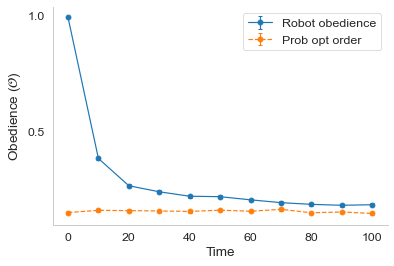

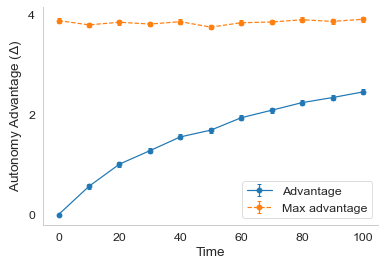

In [5]:
fig_1ab(num_sims=5000, save_file='fig1ab.csv')

# Effect of Rationality on Autonomy Advantage

Effect of Rationality on Autonomy Advantage
Eventually, the robot can gain a higher autonomy advantage for more irrational humans. As before, with a more rational human it takes longer for the robot to converge to the maximum advantage because the evidence the robot gets about the reward is noisier.
This experiment was preformed with features values of 3,5,7,10,15.

In [6]:
def sim_adv_by_rat(rationalities, times, num_feats=15, num_actions=10, num_sims=100):
    horizon = max(times)
    robot = Robot(num_feats)
    humans = [Human(rationality) for rationality in rationalities]
    data = np.zeros((len(times), num_sims, len(rationalities)))
    max_advs = np.zeros((num_sims*len(times), len(rationalities)))
    for sim_num in range(num_sims):
        game = Game(num_actions, horizon+1, 
            np.zeros(num_feats), np.identity(num_feats), 
            np.zeros(num_feats), np.identity(num_feats))
        for human_ind, human in enumerate(humans):
            orders = human.get_orders(game)
            for time_ind, time in enumerate(times):
                curr_data = get_data_at_time(game, robot, human, orders, time)
                data[time_ind][sim_num][human_ind] = curr_data[2]
                max_advs[sim_num*len(times)+time_ind][human_ind] = curr_data[3]
    return data, max_advs

def plot_adv_by_rat(data, rationalities, max_advs, times):
    palette = sns.cubehelix_palette(5, start=2.6, rot=0, dark=0.1, light=.8)
    for time, exp_at_time in zip(times, data):
        mean, stderrs = get_mean_stderr(exp_at_time)
        with palette:
            (_, caps, _) = plt.errorbar(x=rationalities, y=mean, yerr=stderrs, 
                label='{0}'.format(time), marker='o', markersize=4)
            for cap in caps:
                cap.set_markeredgewidth(1)
    mean, stderrs = get_mean_stderr(max_advs)
    (_, caps, _) = plt.errorbar(x=rationalities, y=mean, yerr=stderrs,
                 label='$\infty$', linestyle='--', color=palette[-1], marker='o', markersize=4)
    for cap in caps:
        cap.set_markeredgewidth(1)
    plt.xticks(np.arange(0, max(rationalities)+1, 1.0))
    #plt.locator_params(axis='y', nticks=3)
    #plt.locator_params(axis='x', nticks=3)
    plt.xlim(min(rationalities))
    plt.legend(loc='upper left', title= 'Time:')
    
def save_adv_by_rat_data(filename, data, rationalities, max_advs, times):
    # copy and pasted from above csv
    csv_data = []
    for time, exp_at_time in zip(times, data):
        mean, stderrs = get_mean_stderr(exp_at_time)
        csv_data.append([time] + mean.tolist() + stderrs.tolist())
    max_adv_mean, max_adv_err = get_mean_stderr(max_advs)
    csv_data.append(['Max'] + max_adv_mean.tolist() + max_adv_err.tolist())
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Time'] + ['Rationality: {0}'.format(rat) for rat in rationalities]
                        + ['Stderr Rationality: {0}'.format(rat) for rat in rationalities])
        writer.writerows(csv_data)

def fig2(num_sims, save_file=None):
    rationalities = [1, 2, 5, 10]
    times = [0, 10, 100, 500]
    data, max_advs = sim_adv_by_rat(rationalities, times, num_sims=num_sims, num_actions=10)
    if save_file is not None:
        save_adv_by_rat_data(save_file, data, rationalities, max_advs, times)
    plot_adv_by_rat(data, rationalities, max_advs, times)

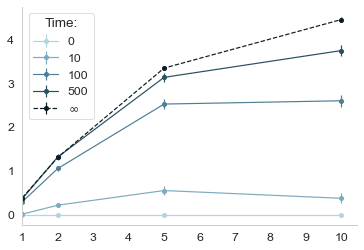

In [7]:
fig2(num_sims=1000, save_file='fig2.csv')